In [39]:

!pip install -q transformers timm pillow matplotlib torch torchvision




In [40]:

from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
from io import BytesIO
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)


Device: cpu


In [41]:

def load_image(path_or_pil):
    if isinstance(path_or_pil, Image.Image):
        return path_or_pil.convert('RGB')
    return Image.open(path_or_pil).convert('RGB')


def visualize_overlay(image, mask, alpha=0.45, figsize=(8,8), color=(1.0, 0.9, 0.0)):


    if hasattr(image, "size") and hasattr(image, "convert"):
        img_w, img_h = image.size
        image_np = np.array(image.convert("RGB"))
    else:
        image_np = np.asarray(image)
        img_h, img_w = image_np.shape[:2]


    if hasattr(mask, "cpu") and hasattr(mask, "numpy"):
        mask_np = mask.detach().cpu().numpy()
    else:
        mask_np = np.array(mask)

    mask_np = np.squeeze(mask_np)
    if mask_np.ndim != 2:
        raise ValueError(f"Mask must be 2D after squeeze, got shape {mask_np.shape}")

    if mask_np.dtype == bool:
        mask_np = mask_np.astype(float)
    else:
        if mask_np.max() > 1.0:
            mask_np = mask_np.astype(float) / float(mask_np.max())

    mask_h, mask_w = mask_np.shape
    if (mask_h, mask_w) != (img_h, img_w):
        mask_img = Image.fromarray((mask_np * 255).astype("uint8"))
        mask_img = mask_img.resize((img_w, img_h), resample=Image.NEAREST)
        mask_np = np.array(mask_img).astype(float) / 255.0

    overlay = np.zeros((img_h, img_w, 4), dtype=float)
    overlay[..., :3] = color
    overlay[..., 3] = mask_np * alpha

    plt.figure(figsize=figsize)
    plt.imshow(image_np)
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()

def prepare_and_run(processor, model, image, prompt, device=device):
    inputs = processor(text=[prompt], images=image, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    mask = outputs.logits.squeeze().sigmoid().cpu().numpy()
    return mask
def load_image_from_url(url, timeout=15):

    if not url:
        raise ValueError("Empty URL passed to load_image_from_url.")
    if requests is not None:
        try:
            resp = requests.get(url, timeout=timeout)
            resp.raise_for_status()
            return Image.open(BytesIO(resp.content)).convert("RGB")
        except Exception as e:
            print("requests fetch failed:", e)

    try:
        from urllib.request import urlopen
        with urlopen(url, timeout=timeout) as resp:
            return Image.open(BytesIO(resp.read())).convert("RGB")
    except Exception as e:
        raise RuntimeError(f"Failed to fetch image using both requests and urllib: {e}")


In [42]:

model_id = 'CIDAS/clipseg-rd64-refined'
clipseg_processor = CLIPSegProcessor.from_pretrained(model_id)
clipseg_model = CLIPSegForImageSegmentation.from_pretrained(model_id).to(device)


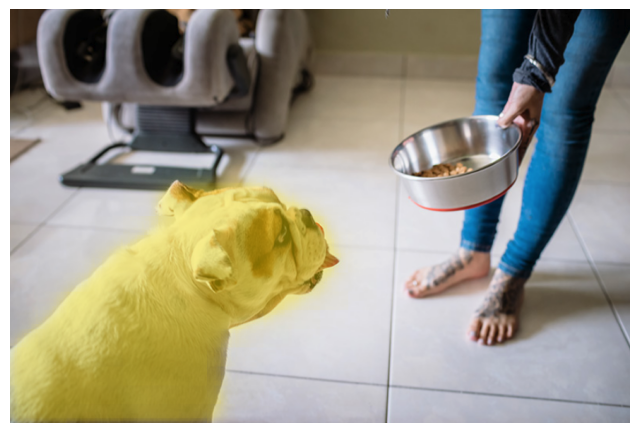

(np.float64(-0.5), np.float64(877.5), np.float64(585.5), np.float64(-0.5))

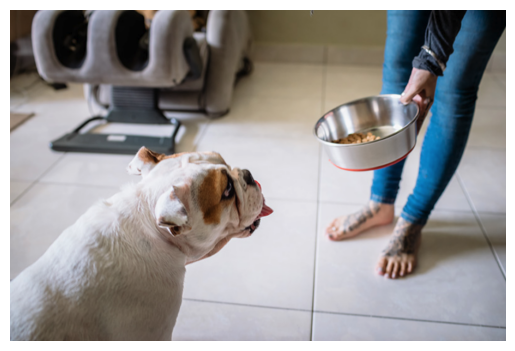

In [43]:
image_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/dog-sam.png"

prompt = 'a dog'
if not os.path.exists(image_path):
    print(f"Image '{image_path}' not found. Upload a file or change the path before running this cell.")
else:
    raw_image = load_image_from_url(image_url)
    mask = prepare_and_run(clipseg_processor, clipseg_model, raw_image, prompt)
    visualize_overlay(raw_image, mask)
plt.imshow(raw_image)
plt.axis('off')
